In [34]:
import pandas as pd
from playwright.async_api import async_playwright
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless = False)
page = await browser.new_page()
from tqdm.notebook import tqdm
import time
import pdb
import csv
from PIL import Image
import requests
import pytesseract

In [35]:
url = 'https://services.ecourts.gov.in/ecourtindia_v6/?p=casestatus/index&app_token=c3c41da3cb5e335b69849006e4de6372a40dda722a50a46fd80a9086c896e86b'

In [36]:
await page.goto(url)

<Response url='https://services.ecourts.gov.in/ecourtindia_v6/?p=casestatus/index&app_token=c3c41da3cb5e335b69849006e4de6372a40dda722a50a46fd80a9086c896e86b' request=<Request url='https://services.ecourts.gov.in/ecourtindia_v6/?p=casestatus/index&app_token=c3c41da3cb5e335b69849006e4de6372a40dda722a50a46fd80a9086c896e86b' method='GET'>>

In [37]:
await page.locator('.alert-danger-cust').get_by_text('Select state, district and court complex to proceed further', exact=True).wait_for()
await page.locator('//*[@id="validateError"]/div/div/div[1]/button').click()

In [38]:
await page.locator('#sess_state_code').select_option('1')

['1']

In [39]:
await page.locator('#sess_dist_code').select_option('26')

['26']

### Ahmednagar, Kopergaon, and Shrirampur are three district courts in Ahmednagar district.

In [40]:
#Ahmednagar
#await page.locator('#court_complex_code').select_option('1010320@1@N')
#Kopergaon
#await page.locator('#court_complex_code').select_option('1010319@7,8,9@N')
#Shrirampur
await page.locator('#court_complex_code').select_option('1010322@18,19,20@N')

['1010322@18,19,20@N']

In [41]:
await page.locator('//*[@id="act-tabMenu"]').click()

In [42]:
await page.locator('#actcode').select_option('1')

['1']

In [43]:
await page.locator('#under_sec').fill('302')

In [44]:
await page.locator('#radPAct').click()

In [45]:
captcha_image = await page.locator('#div_captcha_act #captcha_image').screenshot(type='png')

with open('captcha.png', 'wb') as fp:
    print("Saved as captcha.png")
    fp.write(captcha_image)

Saved as captcha.png


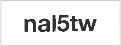

In [46]:
image = Image.open('captcha.png')
image

In [47]:
answer = pytesseract.image_to_string(image).strip()
answer

'nal5tw'

In [48]:
await page.locator('#act_captcha_code').fill(answer)

In [49]:
await page.locator('//*[@id="frm_act"]/div[3]/div[2]/button').click()

In [50]:
table_1 = await page.query_selector_all('tr')

for row in table_1:
    print(await row.text_content())

In [26]:
# headers = ['case_id', 'case_title', 'court_name', ' Case Type', ' Filing Number ',
#        'Registration Number', 'CNR Number', 'First Hearing Date',
#        'Next Hearing Date', 'Case Stage', 'News and Events and Judge', 'Court Number and Judge',
#        'Court Number and Name', 'Case Number and Year', 'Case Decision Date',
#        'Police Station', 'FIR Number', 'Year', 'petitioner_and_advocate',
#        'respondent_and_advocate','Case Transferred from Establishment', 'Transfer Date', 'Case Transferred to Establishment']

# with open('AHMEDNAGAR_SHRIRAMPUR_pending_case_data.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile) # define a writer
#     writer.writerow(headers) # write the row

In [27]:
# async def view_button_click_and_close_error_message(row):
#     view_button = await row.query_selector('a')
#     await view_button.click()
# #     print('clicked view button')
#     error_button = await page.query_selector('//*[@id="validateError"]/div/div/div[1]/button')
#     if error_button.is_visible():
#         await error_button.click()
# #         print('found error button')
#         raise Exception('error after clicking view')

# Function_1 scrape_weird_first_table()

In [28]:
async def scrape_weird_first_table(table):
    case_detail_table = {}
    all_trs = await table.query_selector_all('tr')
    for tr in all_trs:
        key_element = await tr.query_selector_all('td')
        key = await key_element[0].text_content()
        value_element = await tr.query_selector_all('td')
        value = await value_element[1].text_content()
        case_detail_table[key] = value
    return case_detail_table

# Function_2 scrape_side_by_side_table()

In [29]:
async def scrape_side_by_side_table(table):
    case_status_table = {}
    all_trs = await table.query_selector_all('tr')
    for tr in all_trs:
        all_tds = await tr.query_selector_all('td')
        if len(all_tds) == 2:
            left_column = await tr.query_selector_all('td')
            keys = await left_column[0].text_content()
            right_column = await tr.query_selector_all('td')
            values = await right_column[1].text_content()
            case_status_table[keys] = values
        else:
            pass
    return case_status_table

# Function_3 scrape_dataframe_style_table()

In [30]:
async def scrape_dataframe_style_table(table):
    tables = pd.read_html(await page.content())
    return tables[5]

# Scraping (Petitioner + Respondent) & Advocates

## petitioner_and_advocate_table
#### Save all tds in form of a list and add the list as value to the result dictionary
#### This will take care of pages where there are multiple tds which means multiple petitioners

In [31]:
# petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
# all_trs = await petitioner_and_advocate_table.query_selector_all('tr')
# petitioner_advocate = {}
# petitioner_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         petitioner_and_advocate.append(await td.text_content())
#         petitioner_advocate['petitioner_and_advocate'] = petitioner_and_advocate
#     print(petitioner_advocate)          

## respondent_and_advocate_table
#### Save all tds in form of a list and add the list as value to the result dictionary
#### This will take care of pages where there are multiple tds which means multiple respondents

In [32]:
# respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
# all_trs = await respondent_and_advocate_table.query_selector_all('tr')
# respondent_advocate = {}
# respondent_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         respondent_and_advocate.append(await td.text_content())
#         respondent_advocate['respondent_and_advocate'] = respondent_and_advocate
#     print(respondent_advocate)     

In [33]:
table_1 = await page.query_selector_all('tr')
index=0


for row in tqdm(table_1[1:]):
    index = index + 1
    list_of_cases = []
    each_case = {}
    all_tds = await row.query_selector_all('td')
    if len(all_tds) == 2:
        court_name = await all_tds[0].text_content()
    elif len(all_tds) == 4:
        case_id = await row.query_selector('td:nth-child(2)')
        case_title = await row.query_selector('td:nth-child(3)')
        each_case['case_id'] = (await case_id.text_content())
        each_case['case_title'] = (await case_title.text_content())
        each_case['court_name'] = court_name
    
        ###########################
        # if index==15:
        #    break # for debugging, delete later
        ###########################    

        already_scraped_df = pd.read_csv('AHMEDNAGAR_SHRIRAMPUR_pending_case_data.csv')
        already_scraped_case_ids = list(already_scraped_df['case_id'])
        if each_case['case_id'] in already_scraped_case_ids:
#             print(f"Already scraped {each_case['case_id']}")
            continue # this means go back to the top of the loop without finishing this iteration
        
        print(f"Scraping {each_case['case_id']}")
            
        time.sleep(3)
        
        #Because this case's view button acts weird, we are skipping this case
#         cases_to_skip = ['Sessions Case/100264/2014', 'Sessions Case/100919/2013', 'Sessions Case/100672/2013']
#         if each_case['case_id'] in cases_to_skip:
#             with open('AHMEDNAGAR_SHRIRAMPUR_pending_case_data.csv', 'a') as csvfile:
#                 writer = csv.DictWriter(csvfile, fieldnames=headers)
#                 writer.writerow(each_case)
#             list_of_cases.append(each_case)
#             continue
            
        #Click on view button
        view_button = await row.query_selector('a')
        await view_button.click()
            
        time.sleep(5)

        #Scrape the view contents and put them in each_case

        #case_details
        case_details_table = await page.query_selector('#CSact .case_details_table')
        case_details = await scrape_weird_first_table(case_details_table)
            #print(case_details)

        #case_status
        cases_status_table = await page.query_selector('#CSact .case_status_table')
        cases_status = await scrape_side_by_side_table(cases_status_table)
            #print(cases_status)

        #subordinate court
        lower_court_table = await page.query_selector('#CSact .Lower_court_table')
        if lower_court_table:
            lower_court = await scrape_side_by_side_table(lower_court_table)
        else:
            lower_court = {}
            print("Failed to scrape lower court table")
            #print(lower_court)

        #FIR_details
        FIR_details_table = await page.query_selector('#CSact .FIR_details_table')
        if FIR_details_table:
            FIR_details = await scrape_side_by_side_table(FIR_details_table)
        else:
            FIR_details = {}
            print("Failed to scrape FIR details table")
            #Put the result through pd.DataFrame() after looping
            #print(FIR_details)

        #petitioner_advocate
        petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
        all_trs = await petitioner_and_advocate_table.query_selector_all('tr')
        petitioner_advocate = {}
        petitioner_and_advocate = []
        for tr in all_trs:
            all_tds = await tr.query_selector_all('td')
            for td in all_tds:
                petitioner_and_advocate.append(await td.text_content())
                petitioner_advocate['petitioner_and_advocate'] = petitioner_and_advocate
                #print(petitioner_advocate)

        #respondent_advocate
        respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
        all_trs = await respondent_and_advocate_table.query_selector_all('tr')
        respondent_advocate = {}
        respondent_and_advocate = []
        for tr in all_trs:
            all_tds = await tr.query_selector_all('td')
            for td in all_tds:
                respondent_and_advocate.append(await td.text_content())
                respondent_advocate['respondent_and_advocate'] = respondent_and_advocate
                #print(respondent_advocate)

        #click back button
        back_button = page.locator('#main_back_act')
        await back_button.click()
        
        time.sleep(5)
        
        all_case_data = {**each_case, **case_details, **cases_status, **lower_court, **FIR_details, **petitioner_advocate, **respondent_advocate}

        with open('AHMEDNAGAR_SHRIRAMPUR_pending_case_data.csv', 'a') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=headers)
            writer.writerow(all_case_data)
            
            
            
        list_of_cases.append(all_case_data)

    else:
        raise Exception("Error parsing table. Expected 2 or 4 td elements.")

  0%|          | 0/77 [00:00<?, ?it/s]

Scraping R.C.C./277/2020
Failed to scrape lower court table
Scraping Sessions Case/45/2022
Failed to scrape lower court table
Scraping Sessions Case/37/2022
Failed to scrape lower court table
Scraping Sessions Case/1/2022
Failed to scrape lower court table
Scraping Sessions Case/24/2021
Failed to scrape lower court table
Scraping Sessions Case/23/2021
Failed to scrape lower court table
Scraping Sessions Case/15/2021
Failed to scrape lower court table
Scraping Sessions Case/10/2021
Failed to scrape lower court table
Scraping Sessions Case/25/2020
Failed to scrape lower court table
Scraping Sessions Case/21/2020
Failed to scrape lower court table
Scraping Sessions Case/18/2020
Failed to scrape lower court table
Scraping Sessions Case/4/2020
Failed to scrape lower court table
Scraping Sessions Case/81/2019
Failed to scrape lower court table
Scraping Sessions Case/74/2019
Failed to scrape lower court table
Scraping Sessions Case/69/2019
Failed to scrape lower court table
Scraping Sessions 

AttributeError: 'NoneType' object has no attribute 'click'

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In [26], line 45
     34         #Because this case's view button acts weird, we are skipping this case
     35 #         cases_to_skip = ['Sessions Case/100264/2014', 'Sessions Case/100919/2013', 'Sessions Case/100672/2013']
     36 #         if each_case['case_id'] in cases_to_skip:
   (...)
     42             
     43         #Click on view button
     44         view_button = await row.query_selector('a')
---> 45         await view_button.click()
     47         time.sleep(5)
     49         #Scrape the view contents and put them in each_case
     50 
     51         #case_details

AttributeError: 'NoneType' object has no attribute 'click'


# This error occured after the entire list of 74 was done. Then it tried to scrape more and the tqdm counter said it was looking for 104 even though there were only 74 on the page.

In [ ]:
data_so_far = pd.read_csv('pending_case_data.csv')
data_so_far.to_csv(f'pending_case_data_{pd.Timestamp.now()}.csv')

In [ ]:
#df.to_csv('MAH_pending_302.csv', index=False)

In [ ]:
#pd.read_csv('MAH_pending_302.csv')

In [ ]:
#SAFEKEEPING

# view_button = await page.locator('//*[@id="dispTable"]/tbody/tr[2]/td[4]/a').click()
# #case_details
# case_details_table = await page.query_selector('#CSact .case_details_table')
# case_details = await scrape_weird_first_table(case_details_table)
# print(case_details)

# #case_status
# cases_status_table = await page.query_selector('#CSact .case_status_table')
# cases_status = await scrape_side_by_side_table(cases_status_table)
# print(cases_status)

# #subordinate court
# lower_court_table = await page.query_selector('#CSact .Lower_court_table')
# lower_court = await scrape_side_by_side_table(lower_court_table)
# print(lower_court)

# #FIR_details
# FIR_details_table = await page.query_selector('#CSact .FIR_details_table')
# FIR_details = await scrape_side_by_side_table(FIR_details_table)
# #Put the result through pd.DataFrame() after looping
# print(FIR_details)

# #petitioner_advocate
# petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
# all_trs = await petitioner_and_advocate_table.query_selector_all('tr')
# petitioner_advocate = {}
# petitioner_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         petitioner_and_advocate.append(await td.text_content())
#         petitioner_advocate['petitioner_and_advocate'] = petitioner_and_advocate
#     print(petitioner_advocate)
    
# #respondent_advocate
# respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
# all_trs = await respondent_and_advocate_table.query_selector_all('tr')
# respondent_advocate = {}
# respondent_and_advocate = []
# for tr in all_trs:
#     all_tds = await tr.query_selector_all('td')
#     for td in all_tds:
#         respondent_and_advocate.append(await td.text_content())
#         respondent_advocate['respondent_and_advocate'] = respondent_and_advocate
#     print(respondent_advocate)

In [ ]:
#back_button = await page.locator('//*[@id="main_back_act"]').click()

In [ ]:
#List of tables for reference and mental health

# case_details_table = await page.query_selector('#CSact .case_details_table')
# cases_status_table = await page.query_selector('#CSact .case_status_table')
# petitioner_and_advocate_table = await page.query_selector('#CSact .Petitioner_Advocate_table')
# respondent_and_advocate_table = await page.query_selector('#CSact .Respondent_Advocate_table')
# acts_table = await page.query_selector('#CSact .acts_table')
# lower_court_table = await page.query_selector('#CSact .Lower_court_table')
# FIR_details_table = await page.query_selector('#CSact .FIR_details_table')

In [ ]:
# collect dictionaries for each table
# case_details_data = scrape_weird_first_table(case_details_table)
# case_status_data = scrape_side_by_side_table(case_status_table)

# # combine dictionaries
# case_data = {**case_details_data, **case_status_data}

### case_details_table

In [ ]:
case_details_table = await page.query_selector('#CSact .case_details_table')
case_details = await scrape_weird_first_table(case_details_table)
print(case_details)

### cases_status_table

In [ ]:
cases_status_table = await page.query_selector('#CSact .case_status_table')
cases_status = await scrape_side_by_side_table(cases_status_table)
print(cases_status)

### lower_court_table

In [ ]:
lower_court_table = await page.query_selector('#CSact .Lower_court_table')
lower_court = await scrape_side_by_side_table(lower_court_table)
print(lower_court)

### FIR_details_table

In [ ]:
FIR_details_table = await page.query_selector('#CSact .FIR_details_table')
FIR_details = await scrape_side_by_side_table(FIR_details_table)
#Put the result through pd.DataFrame() after looping
print(FIR_details)

### acts_table

In [ ]:
acts_table = await page.query_selector('#CSact .acts_table')
acts = await scrape_dataframe_style_table(acts_table)
print(acts)